In [1]:
%cd ..

/fs01/home/abbasgln/codes/medAI/projects/tta


In [2]:
import os
from dotenv import load_dotenv
# Loading environment variables
load_dotenv()

import torch
import torch.nn as nn
import typing as tp
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from dataclasses import dataclass, field
import logging
import wandb

import medAI
from medAI.utils.setup import BasicExperiment, BasicExperimentConfig

from utils.metrics import MetricCalculator

from timm.optim.optim_factory import create_optimizer

from einops import rearrange, repeat
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import timm

from copy import copy
import pandas as pd


## Model

In [ ]:
from baseline_experiment import FeatureExtractorConfig

fe_config = FeatureExtractorConfig()

# Create the model
model: nn.Module = timm.create_model(
    fe_config.model_name,
    num_classes=fe_config.num_classes,
    in_chans=1,
    features_only=fe_config.features_only,
    norm_layer=lambda channels: nn.GroupNorm(
                    num_groups=fe_config.num_groups,
                    num_channels=channels
                    ))

CHECkPOINT_PATH = os.path.join(os.getenv("DATA_ROOT"), 'checkpoint_store', '2023-12-14_baseline_gn_resnet10.ckpt')

model.load_state_dict(torch.load(CHECkPOINT_PATH)['model'])
model.eval()
model.cuda()

a = True

## Data

In [ ]:
from baseline_experiment import BaselineConfig
from torchvision.transforms import v2 as T
from torchvision.tv_tensors import Image as TVImage

config = BaselineConfig(fold=1)

class Transform:
    def __init__(selfT, augment=False):
        selfT.augment = augment
        selfT.size = (256, 256)
    
    def __call__(selfT, item):
        patch = item.pop("patch")
        patch = copy(patch)
        patch = (patch - patch.min()) / (patch.max() - patch.min()) \
            if config.instance_norm else patch
        patch = TVImage(patch)
        # patch = T.ToImage()(patch)
        # patch = T.ToTensor()(patch)
        patch = T.Resize(selfT.size, antialias=True)(patch).float()
        
        
        if selfT.augment:
            # Augment support patches
            transform = T.Compose([
                T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomVerticalFlip(p=0.5),
            ])  
            patch = transform(patch)
        
        label = torch.tensor(item["grade"] != "Benign").long()
        return patch, label, item


from datasets.datasets import ExactNCT2013RFImagePatches, CohortSelectionOptions, PatchOptions

train_ds = ExactNCT2013RFImagePatches(
    split="train",
    transform=Transform(augment=False),
    cohort_selection_options=CohortSelectionOptions(
        benign_to_cancer_ratio=config.benign_to_cancer_ratio_train,
        min_involvement=config.min_invovlement,
        remove_benign_from_positive_patients=True,
        fold=config.fold,
    ),
    patch_options=PatchOptions(
        patch_size_mm=config.patch_size_mm,
        needle_mask_threshold=config.needle_mask_threshold,
        prostate_mask_threshold=config.prostate_mask_threshold,
    ),
    debug=config.debug,
)

val_ds = ExactNCT2013RFImagePatches(
    split="val",
    transform=Transform(),
    cohort_selection_options=CohortSelectionOptions(
        benign_to_cancer_ratio=config.benign_to_cancer_ratio_test,
        min_involvement=None,
        fold=config.fold
    ),
    patch_options=PatchOptions(
        patch_size_mm=config.patch_size_mm,
        needle_mask_threshold=config.needle_mask_threshold,
        prostate_mask_threshold=config.prostate_mask_threshold,
    ),
    debug=config.debug,
)
        
test_ds = ExactNCT2013RFImagePatches(
    split="test",
    transform=Transform(),
    cohort_selection_options=CohortSelectionOptions(
        benign_to_cancer_ratio=config.benign_to_cancer_ratio_test,
        min_involvement=None,
        fold=config.fold
    ),
    patch_options=PatchOptions(
        patch_size_mm=config.patch_size_mm,
        needle_mask_threshold=config.needle_mask_threshold,
        prostate_mask_threshold=config.prostate_mask_threshold,
    ),
    debug=config.debug,
)


train_loader = DataLoader(
    train_ds, batch_size=config.batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=config.batch_size, shuffle=False, num_workers=4
)
test_loader = DataLoader(
    test_ds, batch_size=config.batch_size, shuffle=False, num_workers=4
)

Computing positions: 100%|██████████| 1302/1302 [00:08<00:00, 148.50it/s]


In [ ]:
df_train_cores = train_ds.dataset.dataset.__dict__['core_info']
df_val_cores = val_ds.dataset.dataset.__dict__['core_info']
df_test_cores = test_ds.dataset.dataset.__dict__['core_info']

In [ ]:
np.unique(df_test_cores['patient_id'].values)

In [3]:
PATIENT = pd.read_csv(os.path.join(os.getenv("DATA_ROOT"), "cores_dataset", "patient.csv"))
CORE = pd.read_csv(os.path.join(os.getenv("DATA_ROOT"), "cores_dataset", "core.csv"))
FOLDS = pd.read_csv(os.path.join(os.getenv("DATA_ROOT"), "cores_dataset", "5fold_splits.csv"))

In [4]:
patient_id_fold1 = FOLDS[FOLDS['fold_1'] == "test"].id.values
patient_id_fold2 = FOLDS[FOLDS['fold_2'] == "test"].id.values
patient_id_fold1

array([  6,   8,  13,  15,  16,  24,  27,  35,  41,  43,  46,  49,  65,
        71,  72,  79,  95,  99, 104, 110, 112, 116, 118, 121, 125, 127,
       129, 142, 143, 148, 154, 155, 157, 160, 164, 183, 190, 191, 202,
       206, 209, 213, 214, 218, 220, 221, 224, 227, 229, 232, 236, 239,
       247, 251, 254, 255, 259, 261, 265, 280, 284, 285, 292, 294, 300,
       302, 313, 315, 329, 360, 365, 368, 375, 378, 381, 382, 383, 391,
       400, 403, 409, 413, 415, 430, 432, 437, 442, 447, 448, 453, 454,
       456, 469, 477, 481, 483, 487, 507, 514, 517, 518, 519, 525, 528,
       541, 552, 558, 561, 562, 565, 576, 582, 584, 586, 592, 597, 598,
       600, 601, 603, 604, 613, 614, 616, 617, 622, 636, 640, 641, 649,
       651, 652, 665, 668, 669, 672, 677, 678, 690])

In [5]:
centers = PATIENT['center'].unique()
fold1_test_core_df = CORE[CORE['patient_id'].isin(patient_id_fold1)]
fold1_test_core_df
['CRCEO' in tag for tag in fold1_test_core_df['tag']]

split = "test"
num_cores_per_center = {}
for center in centers:
    for fold in range(5):
        patient_id = FOLDS[FOLDS[f'fold_{fold}'] == split].id.values
        fold_split_core_df = CORE[CORE['patient_id'].isin(patient_id)]
        
        num_cores = np.sum([center in tag for tag in fold_split_core_df['tag']])
        try:
            num_cores_per_center[fold][center] = num_cores
        except:
            num_cores_per_center[fold] = {center: num_cores}  

In [6]:
num_cores_per_center

{0: {'CRCEO': 303, 'JH': 125, 'PCC': 324, 'PMCC': 99, 'UVA': 485},
 1: {'CRCEO': 291, 'JH': 119, 'PCC': 321, 'PMCC': 116, 'UVA': 455},
 2: {'CRCEO': 283, 'JH': 115, 'PCC': 314, 'PMCC': 125, 'UVA': 480},
 3: {'CRCEO': 306, 'JH': 133, 'PCC': 302, 'PMCC': 115, 'UVA': 472},
 4: {'CRCEO': 286, 'JH': 124, 'PCC': 338, 'PMCC': 133, 'UVA': 443}}

In [ ]:
fold1_test_core_df[~np.isnan(fold1_test_core_df['primary_grade'])]
len(fold1_test_core_df[fold1_test_core_df['grade'] == 'GS7'])

In [63]:
grades = CORE['grade'].unique()

split = "test"
grade_dist_per_fold = {}
for grade in grades:
    for fold in range(5):
        patient_id = FOLDS[FOLDS[f'fold_{fold}'] == split].id.values
        fold_split_core_df = CORE[CORE['patient_id'].isin(patient_id)]
        
        num_cores_per_grade = len(fold_split_core_df[fold_split_core_df['grade'] == grade])
        
        try:
            grade_dist_per_fold[fold][grade] = num_cores_per_grade
        except:
            grade_dist_per_fold[fold] = {grade: num_cores_per_grade}  

In [64]:
grade_dist_per_fold

{0: {'Benign': 1143, 'GS7': 167, 'GS8': 13, 'GS9': 2, 'GS10': 11},
 1: {'Benign': 1153, 'GS7': 108, 'GS8': 21, 'GS9': 20, 'GS10': 0},
 2: {'Benign': 1152, 'GS7': 116, 'GS8': 40, 'GS9': 9, 'GS10': 0},
 3: {'Benign': 1143, 'GS7': 149, 'GS8': 28, 'GS9': 8, 'GS10': 0},
 4: {'Benign': 1136, 'GS7': 135, 'GS8': 32, 'GS9': 21, 'GS10': 0}}

In [65]:
fold1_test_core_df['pct_cancer'].unique()

array([ nan,  50.,  40., 100.,   7.,   5.,  30.,  45.,  75.,  65.,   2.,
        10.,  25.,  70.,  80.,  90.,  60.,  85.,  15.,  20.,  35.,  95.,
        55.,  99.,   3.])

In [83]:
split = "test"
inv_dist_per_fold = {}
for fold in range(5):
    patient_id = FOLDS[FOLDS[f'fold_{fold}'] == split].id.values
    fold_split_core_df = CORE[CORE['patient_id'].isin(patient_id)]
    
    # inv_dist = np.nan_to_num(fold_split_core_df['pct_cancer'].values)
    inv_dist = fold_split_core_df['pct_cancer'].values
    inv_dist_per_fold[fold] = inv_dist  

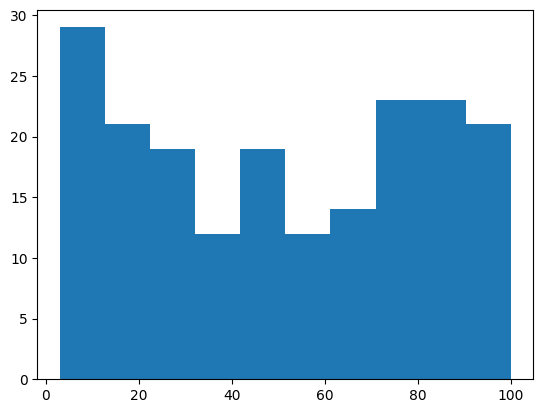

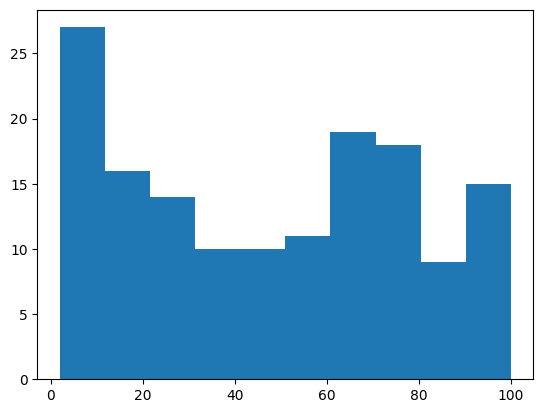

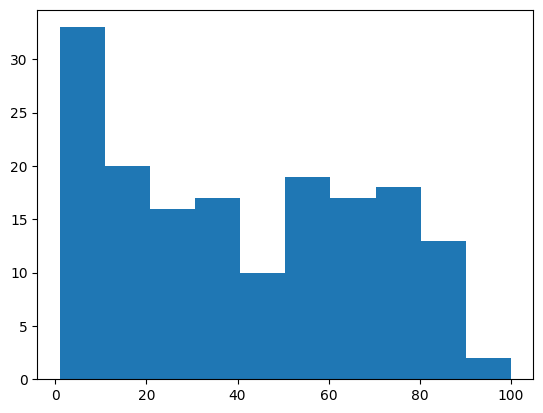

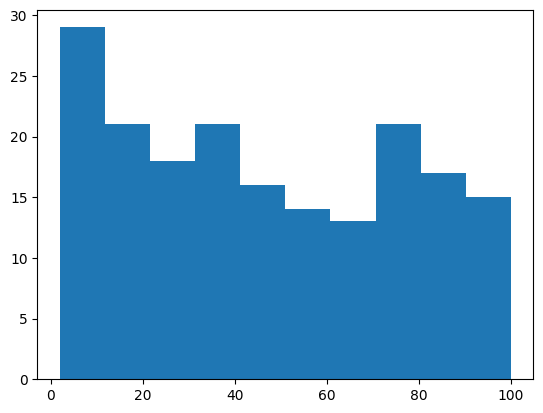

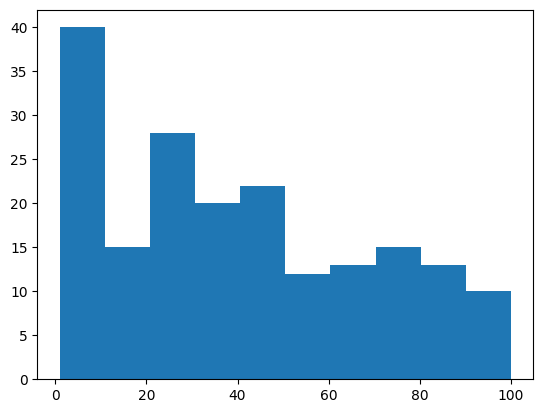

In [87]:
for fold in range(5):
    plt.figure()
    plt.hist(inv_dist_per_fold[fold])